# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = "/content/drive/MyDrive/Landslide4Sense-Internship"
DATA_PATH = f"{BASE_PATH}/data"
CODE_PATH = f"{BASE_PATH}/baseline_code"
CHECKPOINT_DIR = f"{BASE_PATH}/outputs"


Mounted at /content/drive


In [2]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.7 MB/s eta 0:00:00


In [14]:
import torch
import numpy as np
import os
import cv2
import matplotlib as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py

## Data and loading Dataset class
This Section focuses on initializing our .h5 image data. I went through several resources to understand this datatype.

In [15]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


In [6]:

# Load and sketch the Dataset class


class LandSlideHSDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # 1. Load image
        with h5py.File(self.img_paths[idx], 'r') as f:
            img = f['img'][:]  # (H, W, C)

        # 2. Load mask
        with h5py.File(self.mask_paths[idx], 'r') as f:
            m = f['mask'][:]   # (H, W)

        # 3. Transpose image to (C, H, W)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)

        # 4. Convert to tensors
        img_tensor = torch.from_numpy(img)  # shape: (14, 128, 128)
        mask_tensor = torch.from_numpy(m.astype(np.float32))  # shape: (128, 128)

        # 5. Add channel dim to mask -> (1, 128, 128)
        mask_tensor = mask_tensor.unsqueeze(0)

        # 6. Apply transform
        if self.transform:
            # Note to self: Albumentations expects HWC, so skip here or choose PyTorch transforms
            raise NotImplementedError("Add transforms here if needed")

        # 7. Return pair
        return img_tensor, mask_tensor

ds = LandSlideHSDataset(
    img_paths=[
        f"{DATA_PATH}/TrainData/img/image_1.h5",
        f"{DATA_PATH}/TrainData/img/image_2.h5"
    ],
    mask_paths=[
        f"{DATA_PATH}/TrainData/mask/mask_1.h5",
        f"{DATA_PATH}/TrainData/mask/mask_2.h5"
    ]
)
print(len(ds))
i, m = ds[0]
print("Image shape:", i.shape)
print("Mask shape:", m.shape)

2
Image shape: torch.Size([14, 128, 128])
Mask shape: torch.Size([1, 128, 128])


In [7]:
# Use Dataloaders and split the Training data into a 80/20 Split.

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"

all_img_paths = sorted([
    os.path.join(img_dir,  fname)
    for fname in os.listdir(img_dir)
    if fname.endswith('.h5')
])

all_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.h5')
])

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# This will shuffle and split in one go:
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths,
    test_size=0.2,      # 20% validation
    random_state=42     # fixed seed for reproducibility
)

train_ds = LandSlideHSDataset(img_train, mask_train)
val_ds   = LandSlideHSDataset(img_val,   mask_val)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# Check lengths & shapes
print(len(train_loader), len(val_loader))
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)



380 95
torch.Size([8, 14, 128, 128]) torch.Size([8, 1, 128, 128])


## Model Initialization

i initialize and set up the loss, network and optimizer here.

In [8]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate the network
model = smp.Unet(
    encoder_name='resnet34',
    in_channels=14,
    classes=1,
    activation=None
).to(device)

# 2) Losses
bce = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode='binary')   # binary since mask 0/1
def combined_loss(logits, targets):
    return bce(logits, targets) + dice(torch.sigmoid(logits), targets)

# 3) Optimizer
optim = optim.Adam(model.parameters(), lr=1e-4)

print("Model, losses & optimizer ready on", device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model, losses & optimizer ready on cuda


## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [9]:
# Evaluating and developing the training loop
from tqdm import tqdm
from time import sleep

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Training', leave=False)
    for images, masks in loop:
        batch_count += 1

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg = running_loss / batch_count
        loop.set_postfix(train_loss=f"{avg:.4f}")

    return running_loss / batch_count  # no more len(loader)


def validate_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for images, masks in loop:
            batch_count += 1

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss    = combined_loss(outputs, masks)

            running_loss += loss.item()
            avg = running_loss / batch_count
            loop.set_postfix(val_loss=f"{avg:.4f}")

    return running_loss / batch_count



[DEV] E1 → train=1.5208, val=1.4908 ← new best!


[DEV] E2 → train=1.4138, val=1.3489 ← new best!


[DEV] E3 → train=1.3269, val=1.3021 ← new best!


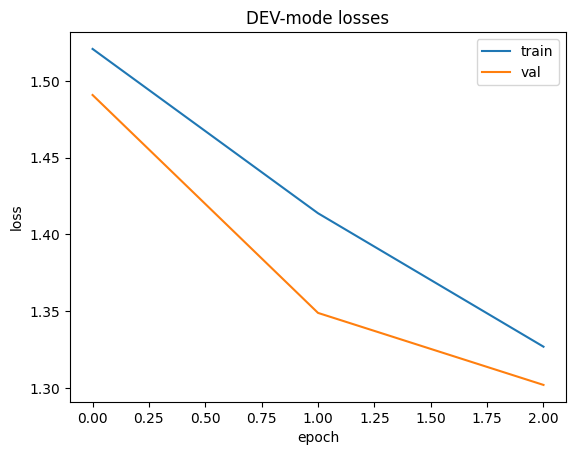

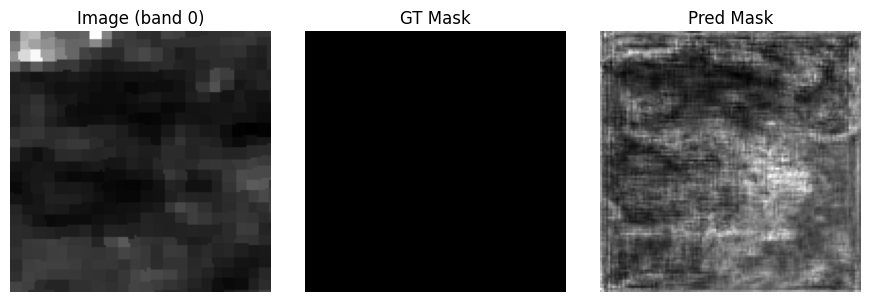

In [11]:
import pickle
import matplotlib.pyplot as plt
from itertools import islice

# 1) helpers to shrink loader
def small_loader(loader, max_batches=20):
    return islice(loader, max_batches)

# 2) containers for logging
train_losses, val_losses = [], []
best_val = float('inf')

# 3) dev run: just 3 “mini-epochs”
DEV_EPOCHS = 3
for epoch in range(1, DEV_EPOCHS+1):
    # 3a) train on first 20 batches only
    tr = train_one_epoch(model, small_loader(train_loader, 20),
                         optim, device)
    # 3b) validate on first 5 batches
    va = validate_one_epoch(model, small_loader(val_loader, 5),
                            device)

    train_losses.append(tr); val_losses.append(va)
    print(f"[DEV] E{epoch} → train={tr:.4f}, val={va:.4f}"
          + (" ← new best!" if va<best_val else ""))

    # 3c) checkpoint best
    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), 'dev_best.pth')

# 4) save logs so you don’t have to re-run dev again
with open('dev_logs.pkl','wb') as f:
    pickle.dump((train_losses, val_losses), f)

# 5) plot the small-epoch curves
plt.plot(train_losses, label='train')
plt.plot(val_losses,   label='val')
plt.title("DEV-mode losses")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.show()

# 6) load best dev checkpoint & quick sample output
model.load_state_dict(torch.load('dev_best.pth', map_location=device))
model.eval()
imgs, masks = next(iter(val_loader))       # full loader OK now
imgs = imgs.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(imgs))

# show first image, mask & pred
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs[0,0].cpu(), cmap='gray')
plt.title("Image (band 0)")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(masks[0,0], cmap='gray')
plt.title("GT Mask")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(preds[0,0].cpu(), cmap='gray')
plt.title("Pred Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

## Actual Training Loop
This is the main training loop where the whole training takes place. 20 epochs trained and models are saved at checkpoints (in case of interruptions).
The code is designed to be fail-safe and tells us the results we need at the end of this execution.

[E01] train=1.1097, val=1.0388  ← new best!  (364.5s)


[E02] train=1.0214, val=1.0008  ← new best!  (22.3s)


[E03] train=1.0002, val=0.9910  ← new best!  (22.9s)


[E04] train=0.9917, val=0.9810  ← new best!  (23.0s)


[E05] train=0.9851, val=0.9810  ← new best!  (22.8s)


[E06] train=0.9837, val=0.9766  ← new best!  (23.1s)


[E07] train=0.9778, val=0.9762  ← new best!  (23.0s)


[E08] train=0.9775, val=0.9760  ← new best!  (23.1s)


[E09] train=0.9769, val=0.9972  (22.4s)


[E10] train=0.9768, val=0.9785  (22.7s)


[E11] train=0.9746, val=0.9721  ← new best!  (22.4s)


[E12] train=0.9713, val=0.9717  ← new best!  (22.5s)


[E13] train=0.9732, val=0.9722  (22.5s)


[E14] train=0.9691, val=0.9723  (22.6s)


[E15] train=0.9705, val=0.9716  ← new best!  (22.6s)


[E16] train=0.9661, val=0.9724  (22.9s)


[E17] train=0.9683, val=0.9727  (22.7s)


[E18] train=0.9664, val=0.9727  (22.2s)


[E19] train=0.9655, val=0.9752  (22.3s)


[E20] train=0.9648, val=0.9758  (22.2s)


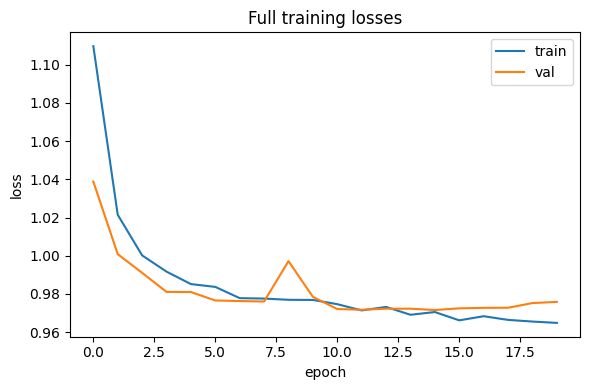

🏆 Best val loss = 0.9716 at epoch 15
→ Loading best model from /content/drive/MyDrive/Landslide4Sense-Internship/outputs/best-epoch15-valloss0.9716.pth



Validation metrics (threshold=0.5):
  Precision: 75.31%
  Recall:    74.10%
  F1 score:  74.70%


In [12]:
import os
import time
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# ─── A) Configuration ──────────────────────────────────────────────────────────────
NUM_EPOCHS     = 20
CHECKPOINT_DIR = f"{BASE_PATH}/outputs"   # e.g. "/content/drive/MyDrive/landslide_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

full_train_losses, full_val_losses = [], []
best_val_loss = float('inf')
best_epoch    = -1

# ─── B) Full training loop with failsafe checkpointing ─────────────────────────────
try:
    for epoch in range(1, NUM_EPOCHS+1):
        start = time.time()

        # 1) train + validate
        tr_loss = train_one_epoch(  model, train_loader, optim, device)
        va_loss = validate_one_epoch(model, val_loader, device)

        full_train_losses.append(tr_loss)
        full_val_losses.append(va_loss)

        # 2) print progress
        msg = f"[E{epoch:02d}] train={tr_loss:.4f}, val={va_loss:.4f}"

        # 3) best‐only checkpoint
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            best_epoch    = epoch
            ckpt = f"best-epoch{epoch:02d}-valloss{va_loss:.4f}.pth"
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, ckpt))
            msg += "  ← new best!"

        # 4) epoch‐wise checkpoint
        ckpt_all = f"epoch{epoch:02d}-valloss{va_loss:.4f}.pth"
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, ckpt_all))

        print(msg + f"  ({time.time()-start:.1f}s)")

except KeyboardInterrupt:
    # 5) Failsafe if you manually interrupt or Colab times out
    print("\n⚠️ Training interrupted! Saving current model…")
    torch.save(model.state_dict(),
               os.path.join(CHECKPOINT_DIR, f"interrupt-epoch{epoch:02d}.pth"))
    raise

# ─── C) Plot the learning curves ───────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(full_train_losses, label="train")
plt.plot(full_val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("Full training losses")
plt.legend(); plt.tight_layout()
plt.show()

print(f"🏆 Best val loss = {best_val_loss:.4f} at epoch {best_epoch}")

# ─── D) Final eval metrics on the best model ───────────────────────────────────────
best_ckpt = os.path.join(
    CHECKPOINT_DIR,
    f"best-epoch{best_epoch:02d}-valloss{best_val_loss:.4f}.pth"
)
print("→ Loading best model from", best_ckpt)
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Final eval", leave=False):
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        preds  = (probs > 0.5).astype(int)
        gt     = masks.numpy().reshape(-1).astype(int)

        y_true.append(gt)
        y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

p = precision_score(y_true, y_pred, zero_division=0)
r = recall_score(   y_true, y_pred, zero_division=0)
f = f1_score(       y_true, y_pred, zero_division=0)

print("\nValidation metrics (threshold=0.5):")
print(f"  Precision: {p*100:5.2f}%")
print(f"  Recall:    {r*100:5.2f}%")
print(f"  F1 score:  {f*100:5.2f}%")